In [1]:
import requests

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'LENwTgeULKJmAfEBkklqJpabZJrdCpvN'
        },
        params=payload
    )

In [2]:
import datetime

from IPython import display # for updating the cell dynamically

current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)

results = []

while current < end:
    # update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')
    
    response = make_request(
        'data', 
        {
            'datasetid': 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
            'locationid': 'CITY:US360019', # NYC
            'startdate': current,
            'enddate': current,
            'units': 'metric',
            'limit': 1000 # max allowed
        }
    )

    if response.ok:
        # we extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])

    # update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

In [ ]:
#The previous step took a while to gather as the program stepped through each day to get the requested data.

In [3]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [4]:
df.to_csv('data/nyc_weather_2018.csv', index=False)

In [5]:
import sqlite3

with sqlite3.connect('data/weather.db') as connection:
    df.to_sql(
        'weather', connection, index=False, if_exists='replace'
    )

In [6]:
response = make_request(
    'stations', 
    {
        'datasetid': 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid': 'CITY:US360019', # NYC
        'limit': 1000 # max allowed
    }
)

stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('data/weather_stations.csv', index=False)

with sqlite3.connect('data/weather.db') as connection:
    stations.to_sql(
        'stations', connection, index=False, if_exists='replace'
    )

In [ ]:
#The previous cells show how we took the data from a csv file and used a loop to isolate the data we want.
#We then took that data and created a dataframe and then a new database using sqlite3.

In [7]:
import pandas as pd

weather = pd.read_csv('data/nyc_weather_2018.csv')
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [8]:
snow_data = weather.query('datatype == "SNOW" and value > 0 and station.str.contains("US1NY")')
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
909,2018-01-04T00:00:00,SNOW,GHCND:US1NYNS0007,",,N,0700",41.0
914,2018-01-04T00:00:00,SNOW,GHCND:US1NYNS0018,",,N,0630",10.0
918,2018-01-04T00:00:00,SNOW,GHCND:US1NYNS0024,",,N,0700",89.0
920,2018-01-04T00:00:00,SNOW,GHCND:US1NYNS0030,",,N,0800",102.0


In [9]:
import sqlite3

with sqlite3.connect('data/weather.db') as connection:
    snow_data_from_db = pd.read_sql(
        'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0 and station LIKE "%US1NY%"', 
        connection
    )

snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [10]:
weather[
    (weather.datatype == 'SNOW') 
    & (weather.value > 0)
    & weather.station.str.contains('US1NY')
].equals(snow_data)

True

In [11]:
station_info = pd.read_csv('data/weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [12]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [13]:
station_info.id.describe()

count                   327
unique                  327
top       GHCND:US1NJBG0015
freq                      1
Name: id, dtype: object

In [14]:
weather.station.describe()

count                 92054
unique                  114
top       GHCND:USW00014734
freq                   6799
Name: station, dtype: object

In [15]:
station_info.shape[0], weather.shape[0]

(327, 92054)

In [16]:
def get_row_count(*dfs):
    return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[327, 92054]

In [17]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
32136,2018-10-04T00:00:00,SNWD,GHCND:USC00066655,",,7,0700",0.0,GHCND:USC00066655,"PUTNAM LAKE, CT US",41.082500,-73.638600,91.4
28528,2018-07-27T00:00:00,PRCP,GHCND:US1NYRL0005,",,N,0700",0.5,GHCND:US1NYRL0005,"WEST NYACK 1.3 WSW, NY US",41.083546,-73.993027,81.7
86343,2018-02-01T00:00:00,PRCP,GHCND:US1NJES0019,",,N,0900",0.0,GHCND:US1NJES0019,"WEST CALDWELL TWP 1.3 NE, NJ US",40.861500,-74.277500,81.4
32971,2018-04-19T00:00:00,TOBS,GHCND:USC00280907,",,7,0700",3.9,GHCND:USC00280907,"BOONTON 1 SE, NJ US",40.891740,-74.396350,85.3
67195,2018-06-14T00:00:00,RHMN,GHCND:USW00094728,",,W,",27.0,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.778980,-73.969250,42.7


In [18]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
32136,2018-10-04T00:00:00,SNWD,GHCND:USC00066655,",,7,0700",0.0,"PUTNAM LAKE, CT US",41.082500,-73.638600,91.4
28528,2018-07-27T00:00:00,PRCP,GHCND:US1NYRL0005,",,N,0700",0.5,"WEST NYACK 1.3 WSW, NY US",41.083546,-73.993027,81.7
86343,2018-02-01T00:00:00,PRCP,GHCND:US1NJES0019,",,N,0900",0.0,"WEST CALDWELL TWP 1.3 NE, NJ US",40.861500,-74.277500,81.4
32971,2018-04-19T00:00:00,TOBS,GHCND:USC00280907,",,7,0700",3.9,"BOONTON 1 SE, NJ US",40.891740,-74.396350,85.3
67195,2018-06-14T00:00:00,RHMN,GHCND:USW00094728,",,W,",27.0,"NY CITY CENTRAL PARK, NY US",40.778980,-73.969250,42.7


In [19]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')

right_join[right_join.datatype.isna()].head()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
0,NaN,NaN,NaN,NaN,NaN,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
343,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
344,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
877,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJBG0005,"WESTWOOD 0.8 ESE, NJ US",40.983041,-74.015858,15.8
878,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJBG0006,"RAMSEY 0.6 E, NJ US",41.058611,-74.134068,112.2


In [20]:
left_join.sort_index(axis=1).sort_values(['date', 'station'], ignore_index=True).equals(
    right_join.sort_index(axis=1).sort_values(['date', 'station'], ignore_index=True)
)

True

In [21]:
get_row_count(inner_join, left_join, right_join)

[92054, 92267, 92267]

In [22]:
outer_join = weather.merge(
    station_info[station_info.id.str.contains('US1NY')], 
    left_on='station', right_on='id', how='outer', indicator=True
)

pd.concat([
    outer_join.query(f'_merge == "{kind}"').sample(2, random_state=0) 
    for kind in outer_join._merge.unique()
]).sort_index()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation,_merge
23154,2018-06-20T00:00:00,PRCP,GHCND:US1NYNS0030,",,N,0800",0.0,GHCND:US1NYNS0030,"PLAINEDGE 0.4 WSW, NY US",40.721382,-73.484241,22.9,both
26513,2018-07-23T00:00:00,PRCP,GHCND:US1NYQN0002,",,N,0700",14.5,GHCND:US1NYQN0002,"MIDDLE VILLAGE 0.5 SW, NY US",40.714521,-73.881893,32.3,both
42640,2018-12-17T00:00:00,WT01,GHCND:USC00301309,",,7,",1.0,NaN,NaN,NaN,NaN,NaN,left_only
76407,2018-11-03T00:00:00,WDF2,GHCND:USW00094745,",,W,",280.0,NaN,NaN,NaN,NaN,NaN,left_only
92079,NaN,NaN,NaN,NaN,NaN,GHCND:US1NYRL0003,"NANUET 0.3 E, NY US",41.095511,-74.009897,86.3,right_only
92089,NaN,NaN,NaN,NaN,NaN,GHCND:US1NYWC0005,"HARRISON 4.1 SSW, NY US",40.963890,-73.723179,24.1,right_only


In [23]:
import sqlite3

with sqlite3.connect('data/weather.db') as connection:
    inner_join_from_db = pd.read_sql(
        'SELECT * FROM weather JOIN stations ON weather.station == stations.id', 
        connection
    )

inner_join_from_db.shape == inner_join.shape

True

In [24]:
dirty_data = pd.read_csv(
    'data/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [25]:
valid_station = dirty_data.query('station != "?"').drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [26]:
valid_station.merge(
    station_with_wesf, how='left', left_index=True, right_index=True
).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [27]:
valid_station.merge(
    station_with_wesf, how='left', left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [28]:
valid_station.join(station_with_wesf, how='left', rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [29]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [30]:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:USC00284987', 'GHCND:US1NJES0031', 'GHCND:US1NJES0029',
       'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097', 'GHCND:US1NJMN0081',
       'GHCND:US1NJMD0088', 'GHCND:US1NJES0033', 'GHCND:US1NJES0040',
       'GHCND:US1NYQN0029'],
      dtype='object', length=114)

In [31]:
weather.index.difference(station_info.index)

Index([], dtype='object')

In [32]:
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=213)

In [33]:
ny_in_name = station_info[station_info.index.str.contains('US1NY')]

ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [34]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=327)

In [35]:
ny_in_name = station_info[station_info.index.str.contains('US1NY')]

ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
    weather.index.symmetric_difference(ny_in_name.index)
)

True

In [ ]:
#The previous cells show how it's possible to query the dtaframe and database. They also show how to join
#dataframes and merge using different types of joins and how to check the shape of the merged dataframe.

In [36]:
import numpy as np
import pandas as pd

weather = pd.read_csv('data/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [37]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [38]:
fb.assign(
    abs_z_score_volume=lambda x: \
        x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [39]:
fb.assign(
    volume_pct_change=fb.volume.pct_change(),
    pct_change_rank=lambda x: \
        x.volume_pct_change.abs().rank(ascending=False)
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [40]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [41]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [42]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

In [43]:
(fb.volume.value_counts() > 1).sum()

0

In [44]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

low     240
med       8
high      3
Name: volume, dtype: int64

In [45]:
fb[volume_binned == 'high'].sort_values('volume', ascending=False)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [46]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [47]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


<AxesSubplot:title={'center':'Daily Volume Traded of Facebook Stock in 2018 (with bins)'}, ylabel='volume traded'>

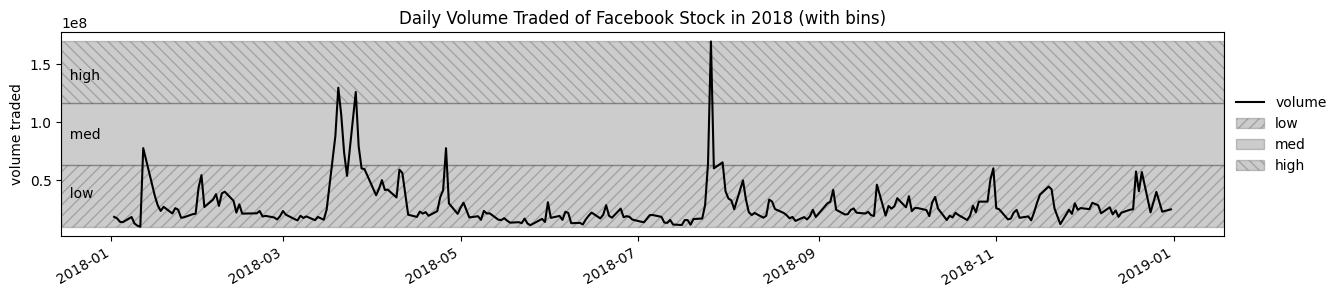

In [48]:
from visual_aids.misc_viz import low_med_high_bins_viz

low_med_high_bins_viz(
    fb, 'volume', ylabel='volume traded',
    title='Daily Volume Traded of Facebook Stock in 2018 (with bins)'
)

In [49]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

q1    63
q2    63
q4    63
q3    62
Name: volume, dtype: int64

<AxesSubplot:title={'center':'Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)'}, ylabel='volume traded'>

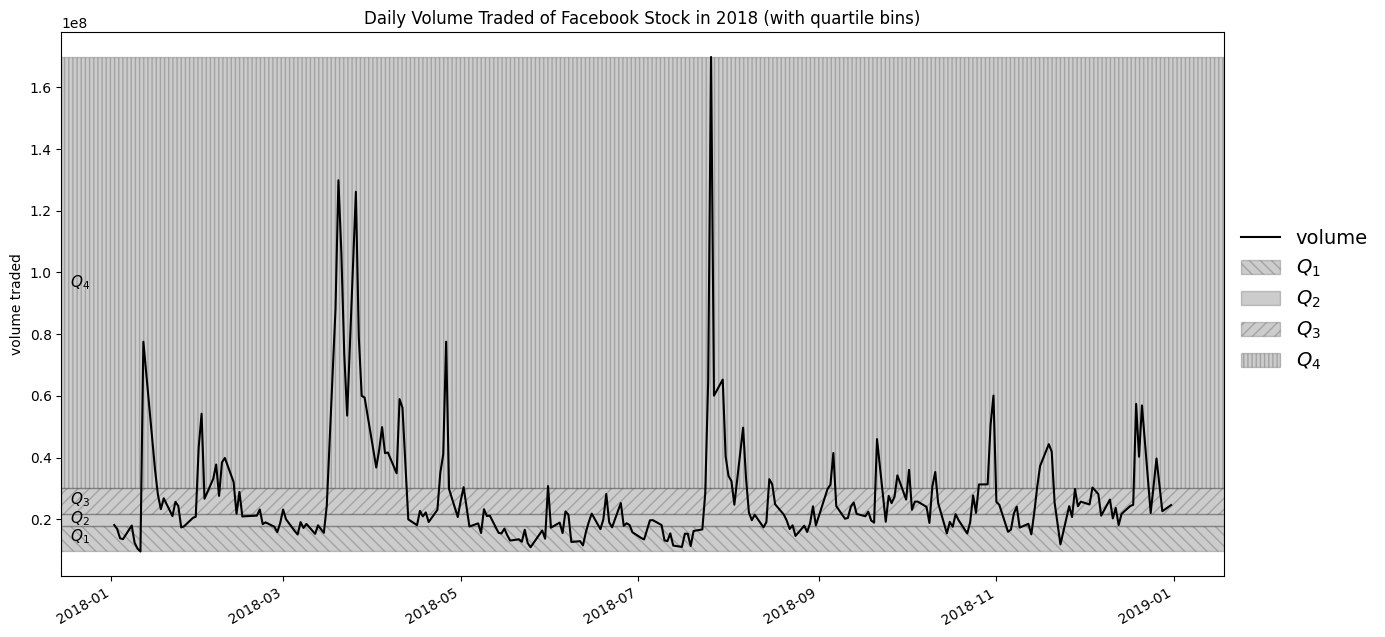

In [50]:
from visual_aids.misc_viz import quartile_bins_viz

quartile_bins_viz(
    fb, 'volume', ylabel='volume traded', 
    title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)'
)

In [51]:
central_park_weather = weather\
    .query('station == "GHCND:USW00094728"')\
    .pivot(index='date', columns='datatype', values='value')

In [52]:
oct_weather_z_scores = central_park_weather\
    .loc['2018-10', ['TMIN', 'TMAX', 'PRCP']]\
    .apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,4.655774e-17,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [53]:
oct_weather_z_scores.query('PRCP > 3').PRCP

date
2018-10-27    3.936167
Name: PRCP, dtype: float64

In [54]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [55]:
fb.apply(
    lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
    fb.applymap(lambda x: len(str(np.ceil(x))))
)

True

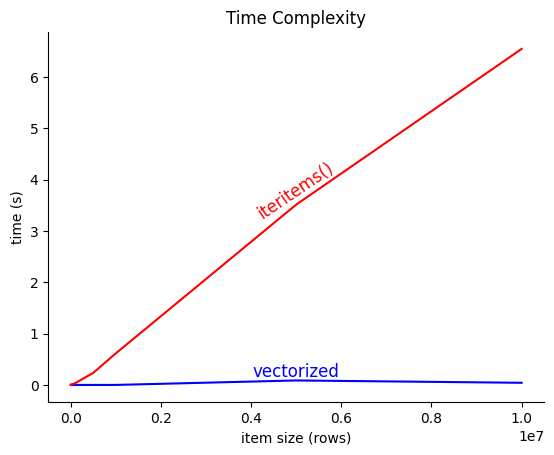

In [56]:
import time

import numpy as np
import pandas as pd

np.random.seed(0)

vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    # set of numbers to use
    test = pd.Series(np.random.uniform(size=size))
    
    # time the vectorized operation
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    # time the operation with `iteritems()`
    start = time.time()
    x = []
    for i, v in test.iteritems():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

results = pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T    

# plotting
ax = results.plot(title='Time Complexity', color=['blue', 'red'], legend=False)

# formatting
ax.set(xlabel='item size (rows)', ylabel='time (s)')
ax.text(0.5e7, iteritems_results[0.5e7] * .9, 'iteritems()', rotation=34, color='red', fontsize=12, ha='center', va='bottom')
ax.text(0.5e7, vectorized_results[0.5e7], 'vectorized', color='blue', fontsize=12, ha='center', va='bottom')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

In [57]:
central_park_weather.loc['2018-10'].assign(
    rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [58]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-01,172.000000,10247.000000,10200.000000,189.000000,0.900000,0.000000
2018-10-02,180.500000,10221.500000,10176.000000,194.500000,0.900000,8.750000
2018-10-03,172.333333,10205.333333,10159.000000,187.000000,0.966667,5.833333
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-06,157.333333,10194.333333,10145.333333,170.333333,0.833333,0.333333
2018-10-07,163.000000,10217.000000,10165.666667,177.666667,1.066667,0.000000


In [59]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [60]:
fb_reindexed = fb\
    .reindex(pd.date_range('2018-01-01', '2018-12-31', freq='D'))\
    .assign(
        volume=lambda x: x.volume.fillna(0),
        close=lambda x: x.close.fillna(method='ffill'),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close)
    )
fb_reindexed.assign(day=lambda x: x.index.day_name()).head(10)

,open,high,low,close,volume,day
2018-01-01,NaN,NaN,NaN,NaN,0.0,Monday
2018-01-02,177.68,181.58,177.5500,181.42,18151903.0,Tuesday
2018-01-03,181.88,184.78,181.3300,184.67,16886563.0,Wednesday
2018-01-04,184.90,186.21,184.0996,184.33,13880896.0,Thursday
2018-01-05,185.59,186.90,184.9300,186.85,13574535.0,Friday
2018-01-06,186.85,186.85,186.8500,186.85,0.0,Saturday
2018-01-07,186.85,186.85,186.8500,186.85,0.0,Sunday
2018-01-08,187.20,188.90,186.3300,188.28,17994726.0,Monday
2018-01-09,188.70,188.80,187.1000,187.87,12393057.0,Tuesday
2018-01-10,186.94,187.89,185.6300,187.84,10529894.0,Wednesday


In [61]:
from pandas.api.indexers import VariableOffsetWindowIndexer

indexer = VariableOffsetWindowIndexer(
    index=fb_reindexed.index, offset=pd.offsets.BDay(3)
)
fb_reindexed.assign(window_start_day=0).rolling(indexer).agg({
    'window_start_day': lambda x: x.index.min().timestamp(),
    'open': 'mean', 'high': 'max', 'low': 'min',
    'close': 'mean', 'volume': 'sum'
}).join(
    fb_reindexed, lsuffix='_rolling'
).sort_index(axis=1).assign(
    day=lambda x: x.index.day_name(),
    window_start_day=lambda x: pd.to_datetime(x.window_start_day, unit='s')
).head(10)

,close,close_rolling,high,high_rolling,low,low_rolling,open,open_rolling,volume,volume_rolling,window_start_day,day
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2018-01-01,Monday
2018-01-02,181.42,181.420000,181.58,181.58,177.5500,177.5500,177.68,177.680000,18151903.0,18151903.0,2018-01-01,Tuesday
2018-01-03,184.67,183.045000,184.78,184.78,181.3300,177.5500,181.88,179.780000,16886563.0,35038466.0,2018-01-01,Wednesday
2018-01-04,184.33,183.473333,186.21,186.21,184.0996,177.5500,184.90,181.486667,13880896.0,48919362.0,2018-01-02,Thursday
2018-01-05,186.85,185.283333,186.90,186.90,184.9300,181.3300,185.59,184.123333,13574535.0,44341994.0,2018-01-03,Friday
2018-01-06,186.85,186.010000,186.85,186.90,186.8500,184.0996,186.85,185.780000,0.0,27455431.0,2018-01-04,Saturday
2018-01-07,186.85,186.220000,186.85,186.90,186.8500,184.0996,186.85,186.047500,0.0,27455431.0,2018-01-04,Sunday
2018-01-08,188.28,186.632000,188.90,188.90,186.3300,184.0996,187.20,186.278000,17994726.0,45450157.0,2018-01-04,Monday
2018-01-09,187.87,187.340000,188.80,188.90,187.1000,184.9300,188.70,187.038000,12393057.0,43962318.0,2018-01-05,Tuesday
2018-01-10,187.84,187.538000,187.89,188.90,185.6300,185.6300,186.94,187.308000,10529894.0,40917677.0,2018-01-06,Wednesday


In [62]:
central_park_weather.loc['2018-06'].assign(
    TOTAL_PRCP=lambda x: x.PRCP.cumsum(),
    AVG_PRCP=lambda x: x.PRCP.expanding().mean()
).head(10)[['PRCP', 'TOTAL_PRCP', 'AVG_PRCP']].T

date,2018-06-01,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10
datatype,,,,,,,,,,
PRCP,6.9,2.00,6.4,4.10,0.00,0.000000,0.000000,0.000,0.000000,0.30
TOTAL_PRCP,6.9,8.90,15.3,19.40,19.40,19.400000,19.400000,19.400,19.400000,19.70
AVG_PRCP,6.9,4.45,5.1,4.85,3.88,3.233333,2.771429,2.425,2.155556,1.97


In [63]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
    {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
    central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']], 
    lsuffix='_expanding'
).sort_index(axis=1)

,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


In [64]:
central_park_weather.assign(
    AVG=lambda x: x.TMAX.rolling('30D').mean(),
    EWMA=lambda x: x.TMAX.ewm(span=30).mean()
).loc['2018-09-29':'2018-10-08', ['TMAX', 'EWMA', 'AVG']].T

date,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08
datatype,,,,,,,,,,
TMAX,22.200000,21.100000,24.400000,25.000000,23.300000,24.400000,21.700000,20.000000,26.100000,23.300000
EWMA,24.410887,24.197281,24.210360,24.261304,24.199285,24.212234,24.050154,23.788854,23.937960,23.896802
AVG,24.723333,24.573333,24.533333,24.460000,24.163333,23.866667,23.533333,23.070000,23.143333,23.196667


In [65]:
def get_info(df):
    return '%d rows, %d columns and max closing Z-score was %d' % (*df.shape, df.close.max())

get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))\
    == fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)

True

In [66]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

In [67]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

In [68]:
from window_calc import window_calc
window_calc??

Signature: window_calc(df, func, agg_dict, *args, **kwargs)
Source:   
def window_calc(df, func, agg_dict, *args, **kwargs):
    """
    Run a window calculation of your choice on a `DataFrame` object.
    
    Parameters:
        - df: The `DataFrame` object to run the calculation on.
        - func: The window calculation method that takes `df`
          as the first argument.
        - agg_dict: Information to pass to `agg()`, could be a
          dictionary mapping the columns to the aggregation
          function to use, a string name for the function,
          or the function itself.
        - args: Positional arguments to pass to `func`.
        - kwargs: Keyword arguments to pass to `func`.
    
    Returns:
        A new `DataFrame` object.
    """
    return df.pipe(func, *args, **kwargs).agg(agg_dict)
File:      c:\users\marc\downloads\itec6720\ch_04\window_calc.py
Type:      function

In [69]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.580,177.5500,181.420,18151903.0
2018-01-03,179.78,183.180,179.4400,183.045,17519233.0
2018-01-04,181.88,184.780,181.3300,184.330,16886563.0
2018-01-05,183.39,185.495,182.7148,184.500,15383729.5
2018-01-08,184.90,186.210,184.0996,184.670,16886563.0


In [70]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.680000,181.580000,177.550000,181.420000,1.815190e+07
2018-01-03,180.480000,183.713333,180.070000,183.586667,1.730834e+07
2018-01-04,183.005714,185.140000,182.372629,184.011429,1.534980e+07
2018-01-05,184.384000,186.078667,183.736560,185.525333,1.440299e+07
2018-01-08,185.837419,187.534839,185.075110,186.947097,1.625679e+07


In [71]:
window_calc(
    central_park_weather.loc['2018-10'], 
    pd.DataFrame.rolling, 
    {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
    '3D'
).head()

,TMAX,TMIN,AWND,PRCP
date,,,,
2018-10-01,24.4,17.2,0.900000,0.0
2018-10-02,25.0,17.2,0.900000,17.5
2018-10-03,25.0,17.2,0.966667,17.5
2018-10-04,25.0,16.1,0.800000,18.5
2018-10-05,24.4,15.6,1.033333,1.0


In [ ]:
#The previous sections covert dataframe operations using weather data and Facebook stock prices.
#It covered arithmatic, binning, functions, and window calculations. The concept of piping was introduced.

In [72]:
import numpy as np
import pandas as pd

fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [73]:
weather = pd.read_csv('data/weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [74]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [75]:
fb.agg({
    'open': np.mean, 
    'high': np.max, 
    'low': np.min, 
    'close': np.mean, 
    'volume': np.sum
})

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [76]:
weather.query('station == "GHCND:USW00094728"')\
    .pivot(columns='datatype', values='value')[['SNOW', 'PRCP']]\
    .sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [77]:
weather.query('station == "GHCND:USW00094728"')\
    .pivot(columns='datatype', values='value')[['SNOW', 'PRCP']]\
    .agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [78]:
fb.agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


In [79]:
fb.groupby('trading_volume').mean()

,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [80]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [81]:
fb_agg = fb.groupby('trading_volume').agg({
    'open': 'mean',
    'high': ['min', 'max'],
    'low': ['min', 'max'],
    'close': 'mean'
})
fb_agg

open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [82]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [83]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


In [84]:
weather.loc['2018-10'].query('datatype == "PRCP"')\
    .groupby(level=0).mean().head().squeeze()

date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.96
Name: value, dtype: float64

In [85]:
weather.query('datatype == "PRCP"').groupby(
    ['station_name', pd.Grouper(freq='Q')]
).sum().unstack().sample(5, random_state=1)

value                                 
date                        2018-03-31 2018-06-30 2018-09-30 2018-12-31
station_name                                                           
WANTAGH 1.1 NNE, NY US          279.90     216.80     472.50     277.20
STATEN ISLAND 1.4 SE, NY US     379.40     295.30     438.80     409.90
SYOSSET 2.0 SSW, NY US          323.50     263.30     355.50     459.90
STAMFORD 4.2 S, CT US           338.00     272.10     424.70     390.00
WAYNE TWP 0.8 SSW, NJ US        246.20     295.30     620.90     422.00

In [86]:
weather.groupby('station_name').filter( # station names with "NY US" in them
    lambda x: x.name.endswith('NY US')
).query('datatype == "SNOW"').groupby('station_name').sum().squeeze() # aggregate and make a series (squeeze)

station_name
ALBERTSON 0.2 SSE, NY US           1087.00
AMITYVILLE 0.1 WSW, NY US           434.00
AMITYVILLE 0.6 NNE, NY US          1072.00
ARMONK 0.3 SE, NY US               1504.00
BROOKLYN 3.1 NW, NY US              305.00
CENTERPORT 0.9 SW, NY US            799.00
CENTERPORT, NY US                  1333.00
ELMSFORD 0.8 SSW, NY US             863.00
FLORAL PARK 0.4 W, NY US           1015.00
HICKSVILLE 1.3 ENE, NY US           716.00
JACKSON HEIGHTS 0.3 WSW, NY US      107.00
JFK INTERNATIONAL AIRPORT, NY US    855.00
LA GUARDIA AIRPORT, NY US           892.00
LOCUST VALLEY 0.3 E, NY US            0.00
LYNBROOK 0.3 NW, NY US              325.00
MASSAPEQUA 0.9 SSW, NY US            41.00
MIDDLE VILLAGE 0.5 SW, NY US       1249.00
NEW HYDE PARK 1.6 NE, NY US           0.00
NEW YORK 8.8 N, NY US                 0.00
NORTH WANTAGH 0.4 WSW, NY US        471.00
NY CITY CENTRAL PARK, NY US        1007.00
PLAINEDGE 0.4 WSW, NY US            610.00
PLAINVIEW 0.4 ENE, NY US           1360.0

In [87]:
weather.query('datatype == "PRCP"')\
    .groupby(level=0).mean()\
    .groupby(pd.Grouper(freq='M')).sum().value.nlargest()

date
2018-11-30   210.59
2018-09-30   193.09
2018-08-31   192.45
2018-07-31   160.98
2018-02-28   158.11
Name: value, dtype: float64

In [88]:
weather.query('datatype == "PRCP"')\
    .rename(dict(value='prcp'), axis=1)\
    .groupby(level=0).mean()\
    .groupby(pd.Grouper(freq='M'))\
    .transform(np.sum)['2018-01-28':'2018-02-03']

,prcp
date,
2018-01-28,69.31
2018-01-29,69.31
2018-01-30,69.31
2018-01-31,69.31
2018-02-01,158.11
2018-02-02,158.11
2018-02-03,158.11


In [89]:
weather\
    .query('datatype == "PRCP"')\
    .rename(dict(value='prcp'), axis=1)\
    .groupby(level=0).mean()\
    .assign(
        total_prcp_in_month=lambda x: \
            x.groupby(pd.Grouper(freq='M')).transform(np.sum),
        pct_monthly_prcp=lambda x: \
            x.prcp.div(x.total_prcp_in_month)
    )\
    .nlargest(5, 'pct_monthly_prcp')

,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


In [90]:
fb[['open', 'high', 'low', 'close']]\
    .transform(lambda x: (x - x.mean()).div(x.std()))\
    .head()

,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


In [91]:
fb.pivot_table(columns='trading_volume')

trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [92]:
fb.pivot_table(index='trading_volume')

,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [93]:
weather.reset_index().pivot_table(
    index=['date', 'station', 'station_name'], 
    columns='datatype', 
    values='value',
    aggfunc='median'
).reset_index().tail()

datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [95]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [96]:
pd.crosstab(
    index=fb.trading_volume,
    columns=fb.index.month,
    colnames=['month'],
    values=fb.close,
    aggfunc=np.mean
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [97]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
    index=snow_data.station_name,
    columns=snow_data.index.month,
    colnames=['month'],
    values=snow_data.value,
    aggfunc=lambda x: (x > 0).sum(),
    margins=True, # show row and column subtotals
    margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9.00
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23.00
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9.00
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11.00
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7.00


In [ ]:
#The previous cells illustrate aggregations using Facebook and weather data. This included summarizaing the dataframes
#and using functions like groupby() and pivot_table. The material is starting to get real abstract and it's not clear how 
#this data manipulation is actually useful. I'm disappointed there is no explanation as to why we want to do these things. 

In [98]:
import numpy as np
import pandas as pd

fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True).assign(
    trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


In [99]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [100]:
fb.loc['2018-q1'].equals(fb['2018-01':'2018-03'])

True

In [101]:
fb.first('1W')

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [102]:
fb.last('1W')

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [103]:
fb_reindexed = fb.reindex(pd.date_range('2018-01-01', '2018-12-31', freq='D'))
fb_reindexed.first('1D').isna().squeeze().all()

True

In [104]:
fb_reindexed.loc['2018-Q1'].first_valid_index()

Timestamp('2018-01-02 00:00:00', freq='D')

In [105]:
fb_reindexed.asof('2018-03-31')

open                  155.15
high                  161.42
low                   154.14
close                 159.79
volume           59434293.00
trading_volume           low
Name: 2018-03-31 00:00:00, dtype: object

In [106]:
stock_data_per_minute = pd.read_csv(
    'data/fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True, 
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)

stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [107]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min', 
    'close': 'last', 
    'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [108]:
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [109]:
stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [110]:
shares_traded_in_first_30_min = stock_data_per_minute\
    .between_time('9:30', '10:00')\
    .groupby(pd.Grouper(freq='1D'))\
    .filter(lambda x: (x.volume > 0).all())\
    .volume.mean()

shares_traded_in_last_30_min = stock_data_per_minute\
    .between_time('15:30', '16:00')\
    .groupby(pd.Grouper(freq='1D'))\
    .filter(lambda x: (x.volume > 0).all())\
    .volume.mean()

shares_traded_in_first_30_min - shares_traded_in_last_30_min

18592.967741935485

In [111]:
pd.DataFrame(
    dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [112]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

In [113]:
fb.assign(
    prior_close=lambda x: x.close.shift(),
    after_hours_change_in_price=lambda x: x.open - x.prior_close,
    abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [114]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [115]:
(
    fb.drop(columns='trading_volume') 
    - fb.drop(columns='trading_volume').shift()
).equals(
    fb.drop(columns='trading_volume').diff()
)

True

In [116]:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [117]:
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


array([<AxesSubplot:title={'center':'raw data'}, xlabel='date', ylabel='events'>,
       <AxesSubplot:title={'center':'daily totals'}, xlabel='date', ylabel='events'>],
      dtype=object)

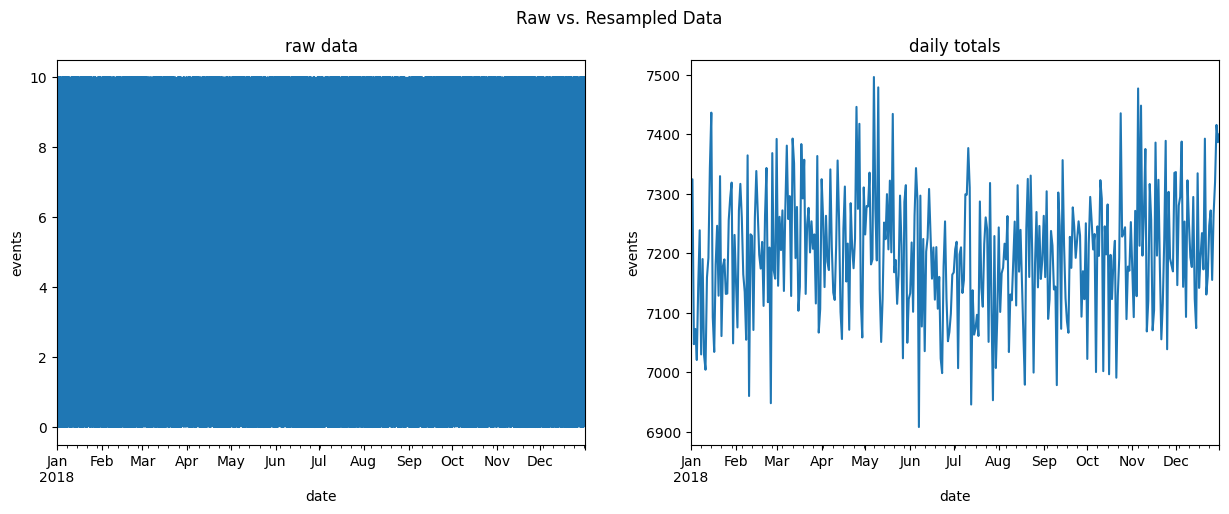

In [118]:
from visual_aids.misc_viz import resampling_example
resampling_example()

In [119]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [120]:
stock_data_per_minute.resample('1D').agg({
    'open': 'first',
    'high': 'max', 
    'low': 'min', 
    'close': 'last', 
    'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [121]:
fb.resample('Q').mean()

,open,high,low,close,volume
date,,,,,
2018-03-31,179.47,181.79,177.04,179.55,32926396.70
2018-06-30,180.37,182.28,178.60,180.70,24055317.75
2018-09-30,180.81,182.89,178.96,181.03,27019824.76
2018-12-31,145.27,147.62,142.72,144.87,26974331.73


In [122]:
fb.drop(columns='trading_volume').resample('Q').apply(
    lambda x: x.last('1D').values - x.first('1D').values
)

,open,high,low,close,volume
date,,,,,
2018-03-31,-22.53,-20.16,-23.41,-21.63,41282390
2018-06-30,39.51,38.40,39.84,38.93,-20984389
2018-09-30,-25.04,-28.66,-29.66,-32.90,20304060
2018-12-31,-28.58,-31.24,-31.31,-31.35,-1782369


In [123]:
melted_stock_data = pd.read_csv('data/melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [124]:
melted_stock_data.resample('1D').ohlc()['price']

,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [126]:
fb.resample('6H').asfreq().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [125]:
fb.resample('6H').pad().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [127]:
fb.resample('6H').fillna('nearest').head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [128]:
fb.resample('6H').asfreq().assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry forward
    # take the closing price if these aren't available
    open=lambda x: x.open.combine_first(x.close),
    high=lambda x: x.high.combine_first(x.close),
    low=lambda x: x.low.combine_first(x.close)
).head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [129]:
import sqlite3

with sqlite3.connect('data/stocks.db') as connection:
    fb_prices = pd.read_sql(
        'SELECT * FROM fb_prices', connection, 
        index_col='date', parse_dates=['date']
    )
    aapl_prices = pd.read_sql(
        'SELECT * FROM aapl_prices', connection, 
        index_col='date', parse_dates=['date']
    )

In [130]:
fb_prices.index.second.unique()

Int64Index([0], dtype='int64', name='date')

In [131]:
aapl_prices.index.second.unique()

Int64Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19,
            53, 11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50,
            31, 58, 48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32,
            27, 30, 45,  1, 44, 57, 41, 37, 28],
           dtype='int64', name='date')

In [132]:
pd.merge_asof(
    fb_prices, aapl_prices, 
    left_index=True, right_index=True, # datetimes are in the index
    # merge with nearest minute
    direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:33:00,182.95,182.50
2019-05-20 09:34:00,183.06,182.11


In [133]:
pd.merge_ordered(
    fb_prices.reset_index(), aapl_prices.reset_index()
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,NaN
2019-05-20 09:31:52,NaN,182.87
2019-05-20 09:32:00,182.75,NaN
2019-05-20 09:32:36,NaN,182.50


In [134]:
pd.merge_ordered(
    fb_prices.reset_index(), aapl_prices.reset_index(),
    fill_method='ffill'
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.62,183.52
2019-05-20 09:31:00,182.61,183.52
2019-05-20 09:31:52,182.61,182.87
2019-05-20 09:32:00,182.75,182.87
2019-05-20 09:32:36,182.75,182.50


In [ ]:
#The previous cells show more advanced time based funstions that can be used to classify the data and how merging dataframes 
#with different time frame granularity can be acheived. Other topics included shifting for lagged data, difference, and resampling.

In [ ]:
#TASK TWO

In [ ]:
#question1

In [1]:
import pandas as pd

df = pd.read_csv('exercises/earthquakes.csv')

df.head()

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California
4,2.16,md,1539474716050,"10km NW of Avenal, CA",0,California


In [3]:
df[(df.magType == 'mb') & (df.parsed_place == 'Japan') & (df.mag >= 4.9)]

,mag,magType,time,place,tsunami,parsed_place
1563,4.9,mb,1538977532250,"293km ESE of Iwo Jima, Japan",0,Japan
2576,5.4,mb,1538697528010,"37km E of Tomakomai, Japan",0,Japan
3072,4.9,mb,1538579732490,"15km ENE of Hasaki, Japan",0,Japan
3632,4.9,mb,1538450871260,"53km ESE of Hitachi, Japan",0,Japan


In [12]:
df.query("magType == 'mb' and parsed_place == 'Japan' and mag >=4.9")

,mag,magType,time,place,tsunami,parsed_place
1563,4.9,mb,1538977532250,"293km ESE of Iwo Jima, Japan",0,Japan
2576,5.4,mb,1538697528010,"37km E of Tomakomai, Japan",0,Japan
3072,4.9,mb,1538579732490,"15km ENE of Hasaki, Japan",0,Japan
3632,4.9,mb,1538450871260,"53km ESE of Hitachi, Japan",0,Japan


In [ ]:
#Question 1 illustrates the difference between the old way of selecting data with the use of df.query functions.

In [ ]:
#question2

In [17]:
bins = df.query("magType == 'ml'")

In [18]:
bins

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California
6,1.70,ml,1539473176017,"105km W of Talkeetna, Alaska",0,Alaska
...,...,...,...,...,...,...
9325,0.51,ml,1537230344890,"4km WNW of Julian, CA",0,California
9326,1.82,ml,1537230230260,"4km W of Julian, CA",0,California
9328,1.00,ml,1537230135130,"3km W of Julian, CA",0,California
9330,1.10,ml,1537229545350,"9km NE of Aguanga, CA",0,California


In [ ]:
#Output here is different from walk through...not sure why?

In [19]:
bins2 = [0, 1, 2, 3, 4, 5, 6]
pd.cut(bins['mag'], bins=bins2)

0       (1, 2]
1       (1, 2]
2       (3, 4]
3       (0, 1]
6       (1, 2]
         ...  
9325    (0, 1]
9326    (1, 2]
9328    (0, 1]
9330    (1, 2]
9331    (0, 1]
Name: mag, Length: 6803, dtype: category
Categories (6, interval[int64]): [(0, 1] < (1, 2] < (2, 3] < (3, 4] < (4, 5] < (5, 6]]

In [20]:
pd.cut(bins['mag'], bins=bins2).value_counts()

(1, 2]    3105
(0, 1]    2207
(2, 3]     862
(3, 4]     122
(4, 5]       2
(5, 6]       1
Name: mag, dtype: int64

In [ ]:
#This question shows how we can create bins of earthquake magnitude by creating an index of bins and checking the value counts.

In [ ]:
#question3

In [26]:
faang = pd.read_csv('exercises/faang.csv', index_col='date', parse_dates=True)

faang.head()

,ticker,high,low,open,close,volume
date,,,,,,
2018-01-02,FB,181.580002,177.550003,177.679993,181.419998,18151900.0
2018-01-03,FB,184.779999,181.330002,181.880005,184.669998,16886600.0
2018-01-04,FB,186.210007,184.100006,184.899994,184.330002,13880900.0
2018-01-05,FB,186.899994,184.929993,185.589996,186.850006,13574500.0
2018-01-08,FB,188.899994,186.330002,187.199997,188.279999,17994700.0


In [27]:
faang.dtypes

ticker     object
high      float64
low       float64
open      float64
close     float64
volume    float64
dtype: object

In [28]:
import numpy as np

In [32]:
faang.groupby('ticker').resample('1M').agg(
{

'open' : np.mean, 'high' : np.max, 'low' : np.min, 'close' : np.mean, 'volume' : np.sum

}
)

open         high          low        close  \
ticker date                                                             
AAPL   2018-01-31    43.505357    45.025002    41.174999    43.501309   
       2018-02-28    41.819079    45.154999    37.560001    41.909737   
       2018-03-31    43.761786    45.875000    41.235001    43.624048   
       2018-04-30    42.441310    44.735001    40.157501    42.458572   
       2018-05-31    46.239091    47.592499    41.317501    46.384205   
       2018-06-30    47.180119    48.549999    45.182499    47.155357   
       2018-07-31    47.549048    48.990002    45.855000    47.577857   
       2018-08-31    53.121739    57.217499    49.327499    53.336522   
       2018-09-30    55.582763    57.417500    53.825001    55.518421   
       2018-10-31    55.300000    58.367500    51.522499    55.211413   
       2018-11-30    47.954881    55.590000    42.564999    47.808929   
       2018-12-31    41.310789    46.235001    36.647499    41.066579   
AMZN   2018-01-31  1301.377151  1472.579956  1170.510010  1309.010946   
       2018-02-28  1447.113159  1528.699951  1265.930054  1442.363146   
       2018-03-31  1542.160464  1617.540039  1365.199951  1540.367629   
       2018-04-30  1475.841902  1638.099976  1352.880005  1468.220471   
       2018-05-31  1590.474543  1635.000000  1546.020020  1594.903637   
       2018-06-30  1699.088582  1763.099976  1635.089966  1698.823812   
       2018-07-31  1786.305716  1880.050049  1678.060059  1784.649042   
       2018-08-31  1891.957833  2025.569946  1776.020020  1897.851308   
       2018-09-30  1969.239476  2050.500000  1865.000000  1966.077900   
       2018-10-31  1799.630865  2033.189941  1476.359985  1782.058265   
       2018-11-30  1622.323806  1784.000000  1420.000000  1625.483823   
       2018-12-31  1572.922100  1778.339966  1307.000000  1559.443154   
FB     2018-01-31   184.584284   190.660004   175.800003   184.962856   
       2018-02-28   180.721578   195.320007   167.179993   180.269473   
       2018-03-31   173.449524   186.100006   149.020004   173.489522   
       2018-04-30   164.163332   177.100006   150.509995   163.810476   
       2018-05-31   181.910909   192.720001   170.229996   182.930000   
       2018-06-30   194.974763   203.550003   186.429993   195.267620   
       2018-07-31   199.332381   218.619995   166.559998   199.967142   
       2018-08-31   177.598695   188.300003   170.270004   177.492172   
       2018-09-30   164.233158   173.889999   158.869995   164.377368   
       2018-10-31   154.873479   165.880005   139.029999   154.187826   
       2018-11-30   141.762857   154.130005   126.849998   141.635715   
       2018-12-31   137.529475   147.190002   123.019997   137.161052   
GOOG   2018-01-31  1127.200945  1186.890015  1045.229980  1130.770467   
       2018-02-28  1088.629472  1174.000000   992.559998  1088.206839   
       2018-03-31  1096.108085  1177.050049   980.640015  1091.490479   
       2018-04-30  1038.415237  1094.165039   990.369995  1035.696187   
       2018-05-31  1064.021376  1110.750000  1006.289978  1069.275901   
       2018-06-30  1136.396182  1186.286011  1096.010010  1137.626668   
       2018-07-31  1183.464280  1273.890015  1093.800049  1187.590472   
       2018-08-31  1226.156951  1256.500000  1188.239990  1225.671732   
       2018-09-30  1176.878424  1212.989990  1146.910034  1175.808934   
       2018-10-31  1116.082172  1209.959961   995.830017  1110.940411   
       2018-11-30  1054.971424  1095.569946   996.020020  1056.162394   
       2018-12-31  1042.619998  1124.650024   970.109985  1037.420519   
NFLX   2018-01-31   231.269525   286.809998   195.419998   232.908096   
       2018-02-28   270.873158   297.359985   236.110001   271.443683   
       2018-03-31   312.712859   333.980011   275.899994   312.228097   
       2018-04-30   309.129524   338.820007   271.220001   307.466192   
       2018-05-31   329.779541   356.100006   305.730011   331.536819   
       2018

In [ ]:
#The previous question was an example of taking faang stock data and using groupby() on the ticker column.
#We then resampled the data so it's presented by single months

In [ ]:
#question4

In [34]:
import pandas as pd

quakes = pd.read_csv('exercises/earthquakes.csv')

In [35]:
pd.crosstab(index = df.tsunami, columns = df.magType, values=df.mag, aggfunc = 'max')

magType,mb,mb_lg,md,mh,ml,ms_20,mw,mwb,mwr,mww
tsunami,,,,,,,,,,
0,5.6,3.5,4.11,1.1,4.2,NaN,3.83,5.8,4.8,6.0
1,6.1,NaN,NaN,NaN,5.1,5.7,4.41,NaN,NaN,7.5


In [ ]:
#In the previous cell we're told to call dats from the earthquakes.csv file and make a crosstab of the tsunami and magType column.
#The agg funstion is used to show the maxumim magnitude that was observed for each combination, and this leaves several NaN values.

In [ ]:
#question5

In [33]:
faang.groupby('ticker').resample('60D').agg(
{

'open' : np.mean, 'high' : np.max, 'low' : np.min, 'close' : np.mean, 'volume' : np.sum

}
)

open         high          low        close  \
ticker date                                                             
AAPL   2018-01-02    42.762143    45.154999    37.560001    42.800357   
       2018-03-03    43.025183    45.875000    40.157501    42.980671   
       2018-05-02    46.820000    48.549999    43.450001    46.867619   
       2018-07-01    50.187857    55.872501    45.855000    50.302619   
       2018-08-30    55.575793    58.367500    53.080002    55.531159   
       2018-10-29    45.725732    55.590000    36.647499    45.533171   
       2018-12-28    39.503750    39.840000    38.637501    39.246250   
AMZN   2018-01-02  1376.351670  1528.699951  1170.510010  1378.281657   
       2018-03-03  1511.184627  1638.099976  1352.880005  1506.558784   
       2018-05-02  1645.430481  1763.099976  1546.020020  1647.164763   
       2018-07-01  1833.881670  1998.689941  1678.060059  1836.026667   
       2018-08-30  1904.764145  2050.500000  1603.000000  1894.892685   
       2018-10-29  1602.105362  1784.000000  1307.000000  1596.387811   
       2018-12-28  1492.075012  1520.760010  1449.000000  1489.994995   
FB     2018-01-02   182.435237   195.320007   167.179993   182.426190   
       2018-03-03   168.526097   186.100006   149.020004   168.404877   
       2018-05-02   188.678810   203.550003   172.119995   189.314762   
       2018-07-01   188.516667   218.619995   166.559998   188.768094   
       2018-08-30   160.783659   179.789993   143.800003   160.555122   
       2018-10-29   140.578781   156.399994   123.019997   140.395609   
       2018-12-28   134.894997   135.919998   129.949997   132.144997   
GOOG   2018-01-02  1107.526899  1186.890015   992.559998  1108.822614   
       2018-03-03  1065.309750  1177.050049   980.640015  1062.433902   
       2018-05-02  1101.407860  1186.286011  1006.289978  1104.212376   
       2018-07-01  1204.170233  1273.890015  1093.800049  1206.489043   
       2018-08-30  1155.098779  1253.635010  1034.089966  1151.615833   
       2018-10-29  1049.130243  1124.650024   970.109985  1047.579761   
       2018-12-28  1050.289978  1055.560059  1023.590027  1036.344971   
NFLX   2018-01-02   251.920238   301.179993   195.419998   253.331904   
       2018-03-03   311.991464   338.820007   271.220001   310.620489   
       2018-05-02   357.630713   423.209991   305.730011   358.269288   
       2018-07-01   362.122144   419.769989   310.929993   362.787856   
       2018-08-30   355.630489   386.799988   292.299988   352.967560   
       2018-10-29   281.070489   332.049988   231.229996   280.162927   
       2018-12-28   259.050003   270.100006   249.800003   261.869995   

                         volume  
ticker date                      
AAPL   2018-01-02  6.699319e+09  
       2018-03-03  5.384782e+09  
       2018-05-02  4.380126e+09  
       2018-07-01  4.007506e+09  
       2018-08-30  5.759600e+09  
       2018-10-29  7.615634e+09  
       2018-12-28  3.091796e+08  
AMZN   2018-01-02  2.475780e+08  
       2018-03-03  2.514690e+08  
       2018-05-02  1.529847e+08  
       2018-07-01  1.826152e+08  
       2018-08-30  2.534316e+08  
       2018-10-29  3.140356e+08  
       2018-12-28  1.578350e+07  
FB     2018-01-02  1.055135e+09  
       2018-03-03  1.729073e+09  
       2018-05-02  7.623838e+08  
       2018-07-01  1.153582e+09  
       2018-08-30  1.023230e+09  
       2018-10-29  1.171651e+09  
       2018-12-28  4.725290e+07  
GOOG   2018-01-02  7.590790e+07  
       2018-03-03  8.370960e+07  
       2018-05-02  6.251750e+07  
       2018-07-01  5.760070e+07  
       2018-08-30  7.088170e+07  
       2018-10-29  8.370780e+07  
       2018-12-28  2.908100e+06  
NFLX   2018-01-02  4.482408e+08  
       2018-03-03  5.062146e+08  
       2018-05-02  3.800460e+08  
       2018-07-01  4.995917e+08  
       2018-08-30  4.876015e+08  
       2018-10-29  5.326795e+08  
       2018-12-28  2.450170e+07

In [ ]:
#Question 5 continues from this question except it modifies the time interval to 60 days.

In [ ]:
#question6

In [43]:
import pandas as pd

df = pd.read_csv('exercises/faang.csv')

pivot_table = df.pivot_table(index='ticker', values=['open', 'high', 'low', 'close', 'volume'], aggfunc='mean')

print(pivot_table)


              close         high          low         open        volume
ticker                                                                  
AAPL      47.263357    47.748526    46.795877    47.277859  1.360803e+08
AMZN    1641.726176  1662.839839  1619.840519  1644.072709  5.648994e+06
FB       171.510956   173.613347   169.303148   171.472948  2.765860e+07
GOOG    1113.225134  1125.777606  1101.001658  1113.554101  1.741965e+06
NFLX     319.290319   325.219322   313.187330   319.620558  1.146962e+07


In [ ]:
#Question 6 in the previous cell had us make a pivot table with the ticker as the index. this used techniques from previous chapters.

In [ ]:
#question8 (question 7 is out of order below this one)

In [36]:
faang = pd.read_csv('exercises/faang.csv', index_col='date', parse_dates=True)

faang.head()

,ticker,high,low,open,close,volume
date,,,,,,
2018-01-02,FB,181.580002,177.550003,177.679993,181.419998,18151900.0
2018-01-03,FB,184.779999,181.330002,181.880005,184.669998,16886600.0
2018-01-04,FB,186.210007,184.100006,184.899994,184.330002,13880900.0
2018-01-05,FB,186.899994,184.929993,185.589996,186.850006,13574500.0
2018-01-08,FB,188.899994,186.330002,187.199997,188.279999,17994700.0


In [44]:
import pandas as pd

file_path = 'exercises/faang.csv'
faang_df = pd.read_csv(file_path)

faang_df['date'] = pd.to_datetime(faang_df['date'])

events_data = {
    'ticker': ['FB', 'FB', 'FB'],
    'date': ['2018-07-25', '2018-03-19', '2018-03-20'],
    'event': [
        'Disappointing user growth announced after close.', 
        'Cambridge Analytica story', 
        'FTC investigation'
    ]
}
events_df = pd.DataFrame(events_data)

events_df['date'] = pd.to_datetime(events_df['date'])

events_df.set_index(['date', 'ticker'], inplace=True)

merged_df = pd.merge(faang_df, events_df, how='outer', on=['date', 'ticker'])

print(merged_df)


     ticker       date         high          low         open        close  \
0        FB 2018-01-02   181.580002   177.550003   177.679993   181.419998   
1        FB 2018-01-03   184.779999   181.330002   181.880005   184.669998   
2        FB 2018-01-04   186.210007   184.100006   184.899994   184.330002   
3        FB 2018-01-05   186.899994   184.929993   185.589996   186.850006   
4        FB 2018-01-08   188.899994   186.330002   187.199997   188.279999   
...     ...        ...          ...          ...          ...          ...   
1250   GOOG 2018-12-24  1003.539978   970.109985   973.900024   976.219971   
1251   GOOG 2018-12-26  1040.000000   983.000000   989.010010  1039.459961   
1252   GOOG 2018-12-27  1043.890015   997.000000  1017.150024  1043.880005   
1253   GOOG 2018-12-28  1055.560059  1033.099976  1049.619995  1037.079956   
1254   GOOG 2018-12-31  1052.699951  1023.590027  1050.959961  1035.609985   

          volume event  
0     18151900.0   NaN  
1     1688660

In [ ]:
#In the previous example we took the faang data and changed the date datatype to properly merge the create a new dataframe.
#Then we set the index to date and ticker to merge the data using an outer join that retains all the data.
#We also added an event description using the events_data function

In [ ]:
#Question 7

In [37]:
faang.query("ticker == 'AMZN'").apply(lambda x: )

,ticker,high,low,open,close,volume
date,,,,,,
2018-01-02,AMZN,1190.000000,1170.510010,1172.000000,1189.010010,2694500.0
2018-01-03,AMZN,1205.489990,1188.300049,1188.300049,1204.199951,3108800.0
2018-01-04,AMZN,1215.869995,1204.660034,1205.000000,1209.589966,3022100.0
2018-01-05,AMZN,1229.140015,1210.000000,1217.510010,1229.140015,3544700.0
2018-01-08,AMZN,1253.079956,1232.030029,1236.000000,1246.869995,4279500.0
...,...,...,...,...,...,...
2018-12-24,AMZN,1396.030029,1307.000000,1346.000000,1343.959961,7220000.0
2018-12-26,AMZN,1473.160034,1363.010010,1368.890015,1470.900024,10411800.0
2018-12-27,AMZN,1469.000000,1390.310059,1454.199951,1461.640015,9722000.0


In [40]:
faang.loc['2018-Q4'].query("ticker == 'AMZN'").drop(columns = 'ticker').apply(lambda x: x.sub(x.mean()).div(x.std()))

,high,low,open,close,volume
date,,,,,
2018-10-01,2.368006,2.502113,2.337813,2.385848,-1.630411
2018-10-02,2.227302,2.247433,2.190795,2.155037,-0.861879
2018-10-03,2.058955,2.139987,2.068570,2.025489,-0.920345
2018-10-04,1.819474,1.781561,1.850048,1.722816,-0.126582
2018-10-05,1.628173,1.554416,1.642819,1.584748,-0.298771
...,...,...,...,...,...
2018-12-24,-2.159820,-2.187566,-2.179582,-2.226185,-0.141238
2018-12-26,-1.611714,-1.810493,-2.026617,-1.339674,1.123063
2018-12-27,-1.641276,-1.626703,-1.456521,-1.404343,0.849827


In [ ]:
#Question 7 has us find the z score for AMZN for each column using the apply() function to gather Q4 data

In [ ]:
#question9

In [45]:
import pandas as pd

file_path = 'exercises/faang.csv'
faang_df = pd.read_csv(file_path)

faang_df['date'] = pd.to_datetime(faang_df['date'])

faang_df.sort_values(by=['ticker', 'date'], inplace=True)

def normalize_by_first_date(group):
    return group / group.iloc[0]

faang_normalized = faang_df.groupby('ticker')[['open', 'high', 'low', 'close', 'volume']].transform(normalize_by_first_date)

faang_df[['open', 'high', 'low', 'close', 'volume']] = faang_normalized

print(faang_df)


     ticker       date      high       low      open     close    volume
251    AAPL 2018-01-02  1.000000  1.000000  1.000000  1.000000  1.000000
252    AAPL 2018-01-03  1.013059  1.015952  1.013928  0.999826  1.155033
253    AAPL 2018-01-04  1.006790  1.016661  1.013987  1.004470  0.877864
254    AAPL 2018-01-05  1.017818  1.022392  1.019276  1.015906  0.925814
255    AAPL 2018-01-08  1.019211  1.027591  1.024624  1.012133  0.804816
...     ...        ...       ...       ...       ...       ...       ...
999    NFLX 2018-12-24  1.242995  1.195783  1.234064  1.163177  0.870583
1000   NFLX 2018-12-26  1.262088  1.183246  1.192861  1.261600  1.313288
1001   NFLX 2018-12-27  1.267493  1.228636  1.275421  1.271050  1.115648
1002   NFLX 2018-12-28  1.298835  1.278272  1.315349  1.273586  1.002362
1003   NFLX 2018-12-31  1.339450  1.330468  1.326670  1.331178  1.231788

[1255 rows x 7 columns]


In [ ]:
#In the previous cells we were tasked with using the transform() method on the FAANG data to represent all the
#values in terms of the first date in the data. To do so, divide all the values for
#each ticker by the values for the first date in the data for that ticker. This is
#referred to as an index, and the data for the first date is the base (was not exactly sure how this one worked...)

In [ ]:
#question10

In [47]:
#parta

import pandas as pd

file_path = 'exercises/covid19_cases.csv'
covid_df = pd.read_csv(file_path)

covid_df['date'] = pd.to_datetime(covid_df['dateRep'], dayfirst=True)

covid_df.set_index('date', inplace=True)

covid_df['countriesAndTerritories'] = covid_df['countriesAndTerritories'].replace({
    'United_States_of_America': 'USA',
    'United_Kingdom': 'UK'
})

covid_df.sort_index(inplace=True)

print(covid_df.head())


               dateRep  day  month  year  cases  deaths  \
date                                                      
2019-12-31  31/12/2019   31     12  2019      0       0   
2019-12-31  31/12/2019   31     12  2019      0       0   
2019-12-31  31/12/2019   31     12  2019      0       0   
2019-12-31  31/12/2019   31     12  2019      0       0   
2019-12-31  31/12/2019   31     12  2019      0       0   

           countriesAndTerritories geoId countryterritoryCode  popData2019  \
date                                                                         
2019-12-31                 Belgium    BE                  BEL   11455519.0   
2019-12-31                  Mexico    MX                  MEX  127575529.0   
2019-12-31                 Ecuador    EC                  ECU   17373657.0   
2019-12-31                  Russia    RU                  RUS  145872260.0   
2019-12-31             Netherlands    NL                  NLD   17282163.0   

           continentExp  \
date        

In [48]:
#partb

covid_df['cumulative_cases'] = covid_df.groupby('countriesAndTerritories')['cases'].cumsum()

top_5_countries = covid_df.groupby('countriesAndTerritories')['cumulative_cases'].max().nlargest(5).index

top_5_df = covid_df[covid_df['countriesAndTerritories'].isin(top_5_countries)]

max_cases_day = top_5_df.loc[top_5_df.groupby('countriesAndTerritories')['cases'].idxmax()]

print(max_cases_day[['countriesAndTerritories', 'cases']])


           countriesAndTerritories  cases
date                                     
2020-07-30                  Russia   5475
2020-07-30                    Peru   5678
2020-07-30                   India  52123
2020-07-30                  Brazil  69074
2020-07-30                     USA  74985
2020-09-17                   India  97894
2020-09-17                  Russia   5670
2020-09-17                  Brazil  36820
2020-09-17                    Peru   6380
2020-09-17                     USA  24598
2020-08-17                  Brazil  23101
2020-08-17                  Russia   4969
2020-08-17                    Peru  10143
2020-08-17                   India  57981
2020-08-17                     USA  42104
2020-07-18                   India  34884
2020-07-18                    Peru   3951
2020-07-18                  Russia  12640
2020-07-18                  Brazil  34177
2020-07-18                     USA  71494
2020-07-25                  Brazil  55891
2020-07-25                   India

In [49]:
#part c

top_5_df['7_day_avg_cases'] = top_5_df.groupby('countriesAndTerritories')['cases'].transform(lambda x: x.rolling(7).mean())

last_week_df = top_5_df.groupby('countriesAndTerritories').tail(7)

avg_change_last_week = last_week_df.groupby('countriesAndTerritories')['cases'].mean()

print(avg_change_last_week)


countriesAndTerritories
Brazil    30431.285714
India     92575.714286
Peru       5677.428571
Russia     5616.000000
USA       39911.285714
Name: cases, dtype: float64


C:\Users\marc\AppData\Local\Temp\ipykernel_7200\2409216996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['7_day_avg_cases'] = top_5_df.groupby('countriesAndTerritories')['cases'].transform(lambda x: x.rolling(7).mean())


In [ ]:
#intersting error on this cell that I will reseacrh more...

In [50]:
#part d

non_china_df = covid_df[covid_df['countriesAndTerritories'] != 'China']

first_case_date = non_china_df[non_china_df['cases'] > 0].groupby('countriesAndTerritories').idxmin()

print(first_case_date)


                               day      month       year      cases  \
countriesAndTerritories                                               
Afghanistan             2020-04-01 2020-02-25 2020-02-25 2020-02-25   
Albania                 2020-04-01 2020-03-09 2020-03-09 2020-03-12   
Algeria                 2020-03-01 2020-02-26 2020-02-26 2020-02-26   
Andorra                 2020-04-01 2020-03-03 2020-03-03 2020-03-03   
Angola                  2020-06-01 2020-03-22 2020-03-22 2020-03-27   
...                            ...        ...        ...        ...   
Vietnam                 2020-04-01 2020-01-24 2020-01-24 2020-02-03   
Western_Sahara          2020-07-01 2020-04-26 2020-04-26 2020-06-20   
Yemen                   2020-06-01 2020-04-10 2020-04-10 2020-04-10   
Zambia                  2020-05-01 2020-03-19 2020-03-19 2020-03-23   
Zimbabwe                2020-04-01 2020-03-21 2020-03-21 2020-03-21   

                            deaths popData2019  \
countriesAndTerritories   

In [52]:
#part e


cumulative_cases = covid_df.groupby('countriesAndTerritories')['cases'].sum()

cumulative_cases_rank = cumulative_cases.rank(pct=True)

print(cumulative_cases_rank)



countriesAndTerritories
Afghanistan       0.690476
Albania           0.561905
Algeria           0.733333
Andorra           0.271429
Angola            0.404762
                    ...   
Vietnam           0.228571
Western_Sahara    0.219048
Yemen             0.300000
Zambia            0.576190
Zimbabwe          0.500000
Name: cases, Length: 210, dtype: float64


In [ ]:
#The question asks for data analysis on COVID-19 cases, including cleaning data, identifying top countries by cases, finding peak case days, 
#calculating 7-day averages, first case dates, and ranking countries by cases.